<a href="https://colab.research.google.com/github/gitpacho/MineriaDatos/blob/master/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libreries  --  Constant values -- Solar Spectrum

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy.interpolate import interp1d

Kb = 8.6 * 10  ** (-5)           # eV/K
q = 1.602 * 10 ** (-19)          # cm
T = 300                                # T
eps_0 = (8.85 * 10 ** -12) / 10000     # C^2 / (N*cm^2)
c = (3 * 10 ** 8) * 10 ** 9            # nm/s
h = 4.135667731 * 10 ** (-15)          # ev*s
Ref, Trans = 0.1, 1

data = pd.read_csv('espectro_.csv', header=0, delimiter=';', decimal = ",")
df = pd.DataFrame(data)
lamb  = np.array(df.loc[(df['Wvlgth nm'] >= 282.0) & (df['Wvlgth nm'] <= 1400.0), 'Wvlgth nm'])  # nm
I_AM0  = np.array(df.loc[(df['Wvlgth nm'] >= 282.0) & (df['Wvlgth nm'] <= 1400.0), 'Etr W*m-2*nm-1'])
I_AM15  = np.array(df.loc[(df['Wvlgth nm'] >= 282.0) & (df['Wvlgth nm'] <= 1400.0), 'Global tilt  W*m-2*nm-1'])
photon_flux = I_AM15 * lamb / (q * 1240) / 10000   # 1 / (cm² * nm)
I_AM15_  = np.array(df.loc[(df['Wvlgth nm'] >= 282.0) & (df['Wvlgth nm'] <= 100000), 'Global tilt  W*m-2*nm-1'])
P_inc = (integrate.simps(I_AM15_) / 10000) * 1000   # mW / cm²
P_inc

100.28734123567797

#1) InGaN properties

In [3]:
Eg_InN,  Eg_GaN  = 0.77,              3.42
Per_InN, Per_GaN = 15.3,              8.9              #ATLAS
Nc_InN,  Nc_GaN  = 0.9 * 10 ** 18,    2.3 * 10 ** 18
Nv_InN,  Nv_GaN  = 5.3 * 10 ** 19,    1.8 * 10 ** 19
Dn_InN,  Dn_GaN  = 80,                39 
Dp_InN,  Dp_GaN  = 8,                 0.75
taon_InN, Taon_GaN = 1 * 10 ** -9,     0.1 * 10 ** -9    #   10.1016/j.solmat.2009.11.010, (0.1063/1.121581 y #10.1016/S0038-1101(99)00227-0 )
taop_InN, Taop_GaN = 5.4* 10 ** -9,     7 * 10 ** -9     #   10.1063/1.2133892,    #10.1016/S0038-1101(99)00227-0 
def DOS(m): 
    m0 = 9.10938291 * 10 ** -31
    k = Kb * q
    hp = h * q
    return 2 * (2 * np.pi * m * m0 * k * T / (hp ** 2)) ** 1.5 / 1000000
def Difusivity(mob): return (Kb * T) * mob
def intrinsic(Nc, Nv, Eg): return (Nc * Nv) ** 0.5 * np.exp(- Eg / (2 * Kb * T))
def Diffusion_Length(D,t): return (D * t) ** 0.5
def EgInGaN(X): return X * Eg_InN + (1 - X) * Eg_GaN - 1.43 * X * (1 - X)
def electron_effective_mass(X): return 0.12 * X + 0.2 * (1 - X)  #atlas y hindawui
def hole_effective_mass(X): return 0.17 * X + 1 * (1 - X)  #atlas y hindawui
def chiInGaN(x, E): return 4.1 + 0.7 * (3.4 - E)
def PermInGaN(x): return Per_InN * x + Per_GaN * (1 - x)
def electron_lifetime_InGaN(X): return taon_InN * X + Taon_GaN * (1-X) 
def hole_lifetime_InGaN(X): return taop_InN * X + Taop_GaN * (1-X) 

#OPTIC ABSORTION
x_lab = [1, 0.83, 0.69, 0.57, 0.5, 0] 
a = [0.69642, 0.66796, 0.58108, 0.60946, 0.51672, 3.52517]
b = [0.46055, 0.68886, 0.66902, 0.62182, 0.46836, -0.65710]
A1, A2, A3, A4, A5 = np.polyfit(x_lab, a, 4)
B1, B2, B3, B4, B5 = np.polyfit(x_lab, b, 4)
def cte_a(X): return A1 * X ** 4 + A2 * X ** 3 + A3 * X ** 2 + A4 * X + A5
def cte_b(X): return B1 * X ** 4 + B2 * X ** 3 + B3 * X ** 2 + B4 * X + B5
def optical_absorption(X):
    A = cte_a(X) * ((1240/lamb) - EgInGaN(X) )
    B = cte_b(X) * ((1240/lamb) - EgInGaN(X) ) ** 2
    C = A + B
    C[np.where(C < 0)] = 0 
    return (10 ** 5) * (C) ** 0.5 
x_values = np.array([0, 0.2, 0.5, 0.8, 1])
mmax = np.array([1460.7, 684.2, 758.1, 1252.7, 3138.4])
mmin = np.array([295,    386.4, 456.4, 644.3,  774])
cte_values = np.array([0.66, 1.37, 1.04, 0.82, 0.68])
C1, C2, C3, C4, C5 = np.polyfit(x_values, mmax, 4)
D1, D2, D3, D4, D5 = np.polyfit(x_values, mmin, 4)
E1, E2, E3, E4, E5 = np.polyfit(x_values, cte_values, 4)
def mov_max(X): return C1 * X ** 4 + C2 * X ** 3 + C3 * X ** 2 + C4 * X + C5
def mov_min(X): return D1 * X ** 4 + D2 * X ** 3 + D3 * X ** 2 + D4 * X + D5
def gamma(X): return E1 * X ** 4 + E2 * X ** 3 + E3 * X ** 2 + E4 * X + E5
def electron_mobility(X, N): 
    DEN = 1 + ((N / (1 * 10 ** 17)) ** gamma(X))
    return mov_min(X) + ( (mov_max(X) - mov_min(X)) / DEN)
def hole_mobility(X, N):
    DENInN = 1 + ((N / (3 * 10 ** 17)) ** 2)
    DENGaN = 1 + ((N / (3 * 10 ** 17)) ** 2)
    MOVInN = 3 + ( (340 - 3) / DENInN)
    MOVGaN = 3 + ( (170 - 3) / DENGaN)
    return MOVInN * X + MOVGaN * (1 - X)

def IGN_PROPERTIES(N_IGN_n, conc_n):
    Eg_IGN_n    =  EgInGaN(conc_n)
    chi_IGN_n   =  chiInGaN(conc_n, Eg_IGN_n)
    Perm_IGN_n  =  PermInGaN(conc_n)
    me_IGN_n    =  electron_effective_mass(conc_n)
    mh_IGN_n    =  hole_effective_mass(conc_n)
    Nc_IGN_n    =  DOS(me_IGN_n)
    Nv_IGN_n    =  DOS(mh_IGN_n)
    Mp_IGN_n    =  hole_mobility(conc_n, N_IGN_n)  ##########
    Dp_IGN_n    =  Difusivity(Mp_IGN_n)
    tp_IGN_n    =  hole_lifetime_InGaN(conc_n)
    Lp_IGN_n    =  Diffusion_Length(Dp_IGN_n,tp_IGN_n)
    S_IGN_n     =  10 ** 3
    ni_IGN_n    =  intrinsic(Nc_IGN_n, Nv_IGN_n, Eg_IGN_n)
    alpha_IGN_n =  optical_absorption(conc_n)
    return Eg_IGN_n, chi_IGN_n, Perm_IGN_n, Nc_IGN_n, Nv_IGN_n, Dp_IGN_n, tp_IGN_n, Lp_IGN_n, S_IGN_n, ni_IGN_n, alpha_IGN_n


#2) Silicon properties

In [6]:
# SILICON PROPERTIES
me_Si_n = 1.08
mh_Si_n = 0.811
N_Si_n = 10 **15

#optical absortion
data = pd.read_csv('OpticalPropertiesOfSilicon.csv', header=0, delimiter=',', decimal = ".")
df = pd.DataFrame(data)
long  = np.array(df.loc[(df['wavelength(nm)'] >= 100) & (df['wavelength(nm)'] <= 1500.0), 'wavelength(nm)'])  # nm
alfa  = np.array(df.loc[(df['wavelength(nm)'] >= 100) & (df['wavelength(nm)'] <= 1500.0), 'a(/cm)'])
interpolador_cubico = interp1d(long, alfa, kind='cubic')
alpha_Si = interpolador_cubico(lamb)  #funcion para calcular alfa en funcion de lambda
#plt.plot(lamb, alpha_Si, 'k', label="Interpolación cúbico")

#electrical parameters
data = pd.read_csv('taoSi_n.csv', header=0, delimiter=',', decimal = ".")
concentration = np.array(data['concentration'])
tao = np.array(data['tao'])
tn_interpolador = interp1d(concentration, tao, kind = 'cubic')
taoSi_n = float(tn_interpolador(N_Si_n))
data = pd.read_csv('taoSi_p.csv', header=0, delimiter=',', decimal = ".")
concentration = np.array(data['concentration'])
tao = np.array(data['tao'])
tp_interpolador = interp1d(concentration, tao, kind = 'cubic')
taoSi_p = float(tp_interpolador(N_Si_n))

def mobilitySi_n(N): return 68.5 + (1414 - 68.5) / (1 + (N / (9.2 * 10 ** 16)) ** 0.711)  #fosforo
def mobilitySi_p(N): return 44.9 + (470.5 - 44.9) / (1 + (N / (2.23 * 10 ** 17)) ** 0.719) #boro
Eg_Si   =  1.12
chi_Si  =  4.05
Perm_Si =  11.7
Nc_Si   =  DOS(me_Si_n)                          #calculos y Fonash
Nv_Si   =  DOS(mh_Si_n)                          #calculos y Fonash
ni_Si   =  intrinsic(Nc_Si, Nv_Si, Eg_Si)
mobSi_n =  mobilitySi_n(N_Si_n)                    # 1400                             #cm² / (V*s)
mobSi_p =  mobilitySi_p(N_Si_n)                    #450
Dn_Si   =  Difusivity(mobSi_n)                #36     # <=
Dp_Si   =  Difusivity(mobSi_p)                #12     # <=
taon_Si =  tn_interpolador(N_Si_n)                 #1.8 * 10 ** -4   #https://www.researchgate.net/publication/267228694_Modelling_Simulation_and_Optimization_of_n-p-n-p_Silicon_Multilayer_Solar_Cells
taop_Si =  tp_interpolador(N_Si_n)                 #1.9 * 10 ** -4   #https://www.researchgate.net/publication/267228694_Modelling_Simulation_and_Optimization_of_n-p-n-p_Silicon_Multilayer_Solar_Cells
Ln_Si   =  Diffusion_Length(Dn_Si , taon_Si)  #0.08
Lp_Si   =  Diffusion_Length(Dp_Si , taop_Si)  #0.041
Sn_Si   =  10 ** 3
Sp_Si   =  10 ** 3

def SILICON_PROPERTIES(N_Si_p):
    me_Si_p = 1.08
    mh_Si_p = 0.811
    #N_Si_p  = 10 ** 15
    Eg_Si_p    =  1.12
    chi_Si_p   =  4.05
    Perm_Si_p  =  11.7
    me_Si_p    =  1.08
    mh_Si_p    =  0.811
    Nc_Si_p    =  DOS(me_Si_p)
    Nv_Si_p    =  DOS(mh_Si_p)
    Mn_Si_p    =  mobilitySi_n(N_Si_p)   ##########
    Dn_Si_p    =  Difusivity(Mn_Si_p)
    tn_Si_p    =  tn_interpolador(N_Si_p)
    Ln_Si_p    =  Diffusion_Length(Dn_Si_p , tn_Si_p)
    S_Si_p     =  10 ** 3
    ni_Si_p    =  intrinsic(Nc_Si_p, Nv_Si_p, Eg_Si_p)
    alpha_Si_p =  alpha_Si
    return Eg_Si_p, chi_Si_p, Perm_Si_p, Nc_Si_p, Nv_Si_p, Dn_Si_p, tn_Si_p, Ln_Si_p, S_Si_p, ni_Si_p, alpha_Si_p



#3) Basic Functions and simulation J vs V

3.1) Functions. 3.2) Characteristic values. 3.3) Basic simulation J vs V


## 3.1) Basic functions

To calculate the photoelectric response of a single cell

In [7]:
def ni(Nc, Nv, Eg): return (Nc * Nv * np.exp( - Eg / (Kb * T) ) ) ** 0.5
def Vbi(Egn, Egp, chin, chip, Nd, Na, Ncn, Ncp, Nvn, Nvp, nin, nip):
    delta_gap = abs(Egn - Egp)
    delta_ec  = abs(chip - chin)
    delta_ev  = delta_gap - delta_ec
    A = (delta_ec - delta_ev) / 2
    B = Kb * T * np.log(Nd * Na / (nin * nip))
    C = 0.5 * Kb * T * np.log(Ncp * Nvn / (Ncn * Nvp))
    return A + B + C
def region(a, b, epsn, epsp, Nd, Na, Vbi, V):
    A = 2 * epsp * epsn * eps_0 * a * (Vbi - V) * 100
    B = q * b * (epsn * Nd + epsp * Na)
    return (A / B) ** 0.5
def pn0(ni, N): return (ni ** 2 / N)
def j0pn(D, pn0, L, s, w, x):               #A/cm^2
    A = q * D * pn0 / L
    B = s * L / D
    ang = (w - x) / L
    return A * (B * np.cosh(ang) + np.sinh(ang) ) / (B * np.sinh(ang) + np.cosh(ang))
def j00(xn, xp, nin, nip, Lp, Ln, Dp, Dn):   #A/cm^2
    taop = (Lp ** 2) / Dp
    taon = (Ln ** 2) / Dn
    return q * ( (xn * nin / taop) + (xp * nip / taon))
def jdark(j01, j02, j00, v):                    #A/cm^2
    j0 = j01 + j02
    Jnight = (j0 * (np.exp(v / (Kb * T)) - 1)) + (j00 * (np.exp(v / (2 * Kb * T)) - 1))
    return Jnight
def djn(sn, Ln, Dn, wp, xp, alpha2, wn, alpha1, Ref, Trans):
    cte1 = sn * Ln / Dn
    cte2 = wp - xp
    angulo = (wp - xp) / Ln
    A = q * photon_flux * (1 - Ref) * Trans * alpha2 * Ln
    B = np.exp(-(alpha1 * wn + alpha2 * xp))
    C = ((alpha2 ** 2) * (Ln ** 2)) - 1
    D = alpha2 * Ln
    E = cte1 * (np.cosh(angulo) - np.exp( - alpha2 * cte2 ) )
    F = np.sinh(angulo) 
    G = alpha2 * Ln * np.exp(- alpha2 * cte2)
    H = cte1 * np.sinh(angulo)
    I = np.cosh(angulo)
    return (A * B / C) * (D - ( (E + F + G ) / (H + I) ))
def djp(sp, Lp, Dp, wn, xn, alpha1, Ref, Trans):
    cte1 = sp * Lp / Dp
    cte2 = wn - xn
    angulo = (wn - xn) / Lp    
    A = q * photon_flux * (1 - Ref) * Trans * alpha1 * Lp
    B = ((alpha1 ** 2) * (Lp ** 2) ) - 1
    C = cte1 + (alpha1 * Lp)
    D = np.exp(- (alpha1 * cte2))
    E = ( cte1 * np.cosh(angulo) ) + np.sinh(angulo)
    F = ( cte1 * np.sinh(angulo) ) + np.cosh(angulo)
    G = alpha1 * Lp * np.exp( - alpha1 * cte2)
    return (A / B) *  ( ((C - D * E) / F) - G)
def djscr(xn, xp, wn, alpha1, alpha2 , Ref, Trans):
    A = q * photon_flux * (1 - Ref) * Trans * np.exp( - alpha1 * (wn - xn))
    B = 1 - np.exp( - alpha1 * xn)
    C = np.exp( - alpha1 * xn) * (1 - np.exp(- alpha2 * xp))
    return A * (B + C)

## 3.2) Helper function
For get Voc, Jsc, FF, efficiency 

In [8]:
def CHARACTERISTICS_VALUES(J_list, Pot_list, V_list):
    Positives = [x for x in J_list if x > 0]
    Position = len(Positives)
    x1, x2 = V_list[Position - 1], V_list[Position]
    y1, y2 = J_list[Position - 1], J_list[Position]
    m = (y2 - y1) / (x2 - x1)
    
    V_oc = (- y1 / m) + x1
    J_sc = J_list[0] * 1000
    
    Pot_list_ = [x for x in Pot_list if str(x) != 'nan']
    Position = int(np.where(Pot_list_ == np.amax(Pot_list_))[0])
    V_mpp = V_list[Position] 
    J_mpp = J_list[Position] * 1000
    x_n_opt = x_n_list[Position]
    x_p_opt = x_p_list[Position]
    
    FF = ((J_mpp * V_mpp) / (J_sc * V_oc)) * 100
    Eff = (J_mpp * V_mpp) / 100
    return V_oc, J_sc, FF, Eff, x_n_opt, x_p_opt

## 3.3) Function for simulate J vs V behavior

In [9]:
V_list = np.linspace(0, 1, 201)  ##  we shall set the numbers of values of V_list for avoid the excess of operations
ayuda = []
def basic_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p):
    J_list = []
    Pot_list = []
    x_n_list = []
    x_p_list = []


    for V in V_list:
        Eg_IGN_n, chi_IGN_n, Perm_IGN_n, Nc_IGN_n, Nv_IGN_n, Dp_IGN_n, tp_IGN_n, Lp_IGN_n, S_IGN_n, ni_IGN_n, alpha_IGN_n = IGN_PROPERTIES(N_IGN_n = N_IGN_n, conc_n = conc_n)
        Eg_Si_p, chi_Si_p, Perm_Si_p, Nc_Si_p, Nv_Si_p, Dn_Si_p, tn_Si_p, Ln_Si_p, S_Si_p, ni_Si_p, alpha_Si_p = SILICON_PROPERTIES(N_Si_p = N_Si_p)    
        
        #CORRESPONDENCES
        Eg_n,  Eg_p  = Eg_IGN_n,        Eg_Si_p
        chi_n, chi_p = chi_IGN_n,       chi_Si_p
        N_d,   N_a   = N_IGN_n,         N_Si_p
        Nc_n,  Nc_p  = Nc_IGN_n,        Nc_Si_p
        Nv_n,  Nv_p  = Nv_IGN_n,        Nv_Si_p
        eps_n, eps_p = Perm_IGN_n,      Perm_Si_p
        D_p,   D_n   = Dp_IGN_n,        Dn_Si_p#Dp_IGN_n #
        L_p,   L_n   = Lp_IGN_n,        Ln_Si_p#Lp_IGN_n #
        s_p,   s_n   = S_IGN_n ,        S_Si_p
        w_n,   w_p   = w_IGN_n,         w_Si_p 
        alpha_1 = alpha_IGN_n
        alpha_2 = alpha_Si_p
        ni_n = ni_IGN_n
        ni_p = ni_Si_p

        #Operations
        V_bi = Vbi(Eg_n, Eg_p, chi_n, chi_p, N_d, N_a, Nc_n, Nc_p, Nv_n, Nv_p, ni_n, ni_p)
        #print(V_bi)
        x_n = region(N_a, N_d, eps_n, eps_p, N_d, N_a, V_bi, V )
        x_p = region(N_d, N_a, eps_n, eps_p, N_d, N_a, V_bi, V )

        if x_n > w_n:
            x_n = w_n
            x_p = w_n * (N_d / N_a)
        x_n_list.append(x_n)
        x_p_list.append(x_p)
        n_0 = pn0(ni_p, N_a)    #p
        p_0 = pn0(ni_n, N_d)    #n
        j0_n = j0pn(D_n, n_0, L_n, s_n, w_p, x_p)
        j0_p = j0pn(D_p, p_0, L_p, s_p, w_n, x_n)
        j_00 = j00(x_n, x_p, ni_n, ni_p, L_p, L_n, D_p, D_n)
        j_dark = jdark(j0_n, j0_p, j_00, V)
        dj_n    = djn(s_n, L_n, D_n, w_p, x_p, alpha_2, w_n, alpha_1, Ref, Trans)   
        dj_p    = djp(s_p, L_p, D_p, w_n, x_n, alpha_1, Ref, Trans)
        dj_scr  = djscr(x_n, x_p, w_n, alpha_1, alpha_2 , Ref, Trans)
        j_ph = integrate.simps(dj_p + dj_n + dj_scr)
        j_cell = j_ph - j_dark
        J_list.append(j_cell)
        Pot_list.append(V * j_cell)

    return J_list, Pot_list, x_n_list, x_p_list

# -------------------------------------- SIMULATIONS-----------------------------------------------------

> Bloc con sangría



## J vs V **SIMULATIONS**


In [10]:
labels_size = 15
def individual_graph(ax):
    for i, j in enumerate(conc_n_list):
      ax.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
      ax.set_xlim(0, 0.7)
      ax.set_ylim(0, 40)
      ax.text(0.6, 35, r"$J\ vs\ V$", ha="center", va="center", size = 12)
      #ax.set_title('{:.1e}:{:.1e}'.format(w_up, w_down))
      #ax.set_xlabel(r'$Voltaje\ [V]$', size = labels_size)
      ax.grid()
      ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
      ax.set_yticks([10,20,30])        
      plt.tight_layout()


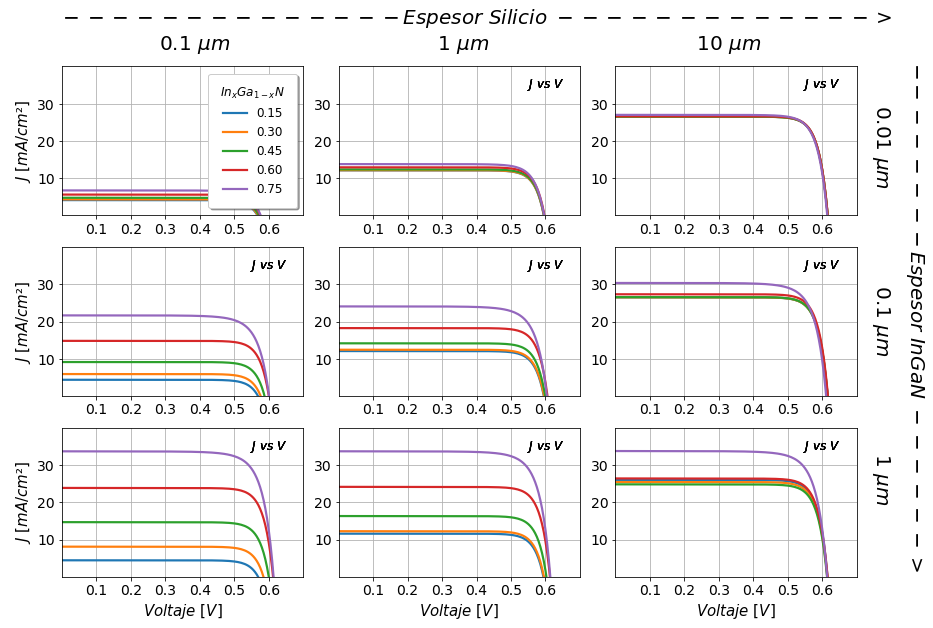

In [11]:
from itertools import product
import matplotlib as mpl
params = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.title_fontsize' : 12}
mpl.rcParams.update(params)
N_IGN_n = 10 ** 17
N_Si_p = 10 ** 16
w_IGN_n_list    =  np.array([0.1, 1, 10]) * 10 ** -5
w_Si_p_list    =  np.array([1, 10, 100]) * 10 ** -5
conc_n_list = np.linspace(0.15 ,0.75, 5)  #np.linspace(0,0.75, 6)
cross_product = product(w_IGN_n_list, w_Si_p_list)
ubication = list(product([0,1,2], [0,1,2]))


fig, ax = plt.subplots(3,3)
fig.set_size_inches(12, 8)
cont = 0
for w_IGN_n, w_Si_p in cross_product:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
    for conc_n in conc_n_list:
        J_list, Pot_list, x_n_list, x_p_list = basic_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
        J_lists.append(J_list)
        Pot_lists.append(Pot_list)
        Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)
    
    a, b = ubication[cont]    
    individual_graph(ax[a, b]) #V_list, np.array(J_lists[i]) * 10 ** 3)
    #ax[a, b].set_title('{:.1e}:{:.1e}'.format(w_up, w_down))
    #if cont in [0, 1, 2]: ax[a, b].set_title(r'${:1.2f} \ \mu m$'.format(w_Si_p * 10 ** 4), size = 15)##################################################here to see the values of width
    if cont == 0: ax[a,b].legend(title = r'$In_{x}Ga_{1-x}N$', fontsize = 12, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc = 'right')
    if cont in [6, 7, 8]: ax[a,b].set_xlabel(r'$Voltaje\ [V]$', size = labels_size)
    if cont in [0,3,6]: ax[a,b].set_ylabel(r'$J\ [mA/cm²]$', size = labels_size) 
    cont += 1

plt.text(0.87, 70, r"$-------- Espesor \ InGaN \ ------>$", ha="center", va="center", rotation=270, size = 20)
plt.text(0.77, 73, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.01,'\ '* 15 ,0.1, '\ '* 15 ,1), ha="center", va="center", rotation=270, size = 20)

plt.text(-0.48, 150, r"$\ \ \ \ \ \ \ \ -------------- Espesor \ Silicio \ ------------->    $", ha="center", va="center", size = 20)
plt.text(-0.45, 143, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.1,'\ '* 32 , 1, '\ '* 32 ,10), ha="center", va="center", size = 20)
plt.show()

## P vs V SIMULATIONS


In [12]:
labels_size = 15
def individual_graph(ax):
    for i, j in enumerate(conc_n_list):
      ax.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
      ax.set_xlim(0, 0.7)
      ax.set_ylim(0, 20)
      ax.text(0.6, 18, r"$J\ vs\ V$", ha="center", va="center", size = 12)
      #ax.set_title('{:.1e}:{:.1e}'.format(w_up, w_down))
      #ax.set_xlabel(r'$Voltaje\ [V]$', size = labels_size)
      ax.grid()
      ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
      ax.set_yticks([5, 10, 15, 20])        
      plt.tight_layout()


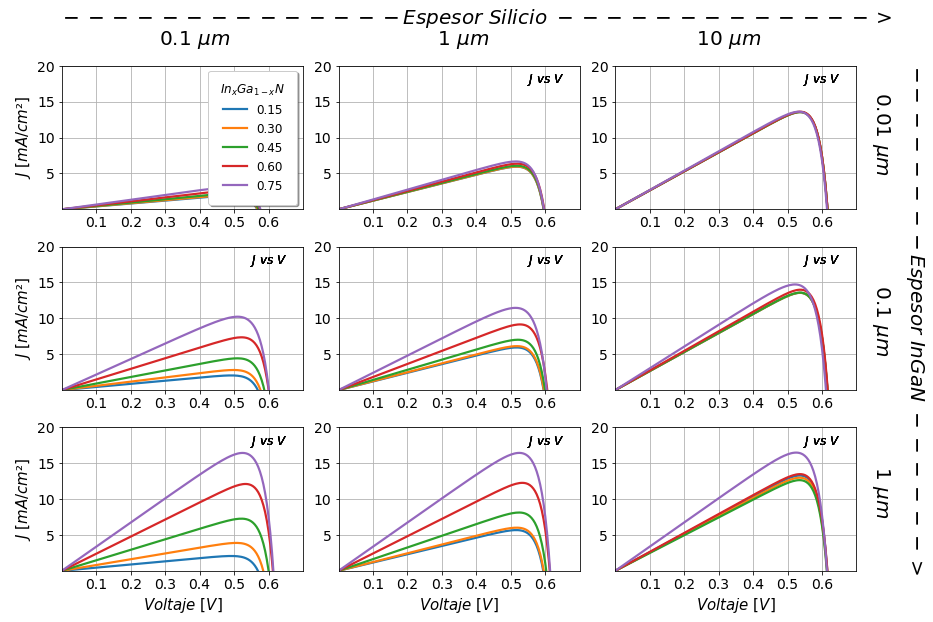

In [13]:
from itertools import product
import matplotlib as mpl
params = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.title_fontsize' : 12}
mpl.rcParams.update(params)
N_IGN_n = 10 ** 17
N_Si_p = 10 ** 16
w_IGN_n_list    =  np.array([0.1, 1, 10]) * 10 ** -5
w_Si_p_list    =  np.array([1, 10, 100]) * 10 ** -5
conc_n_list = np.linspace(0.15 ,0.75, 5)  #np.linspace(0,0.75, 6)
cross_product = product(w_IGN_n_list, w_Si_p_list)
ubication = list(product([0,1,2], [0,1,2]))


fig, ax = plt.subplots(3,3)
fig.set_size_inches(12, 8)
cont = 0
for w_IGN_n, w_Si_p in cross_product:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
    for conc_n in conc_n_list:
        J_list, Pot_list,x_n_list, x_p_list = basic_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
        J_lists.append(J_list)
        Pot_lists.append(Pot_list)
        Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)
    
    a, b = ubication[cont]    
    individual_graph(ax[a, b]) #V_list, np.array(J_lists[i]) * 10 ** 3)
    #ax[a, b].set_title('{:.1e}:{:.1e}'.format(w_up, w_down))
    #if cont in [0, 1, 2]: ax[a, b].set_title(r'${:1.2f} \ \mu m$'.format(w_Si_p * 10 ** 4), size = 15)##################################################here to see the values of width
    if cont == 0: ax[a,b].legend(title = r'$In_{x}Ga_{1-x}N$', fontsize = 12, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc = 'right')
    if cont in [6, 7, 8]: ax[a,b].set_xlabel(r'$Voltaje\ [V]$', size = labels_size)
    if cont in [0,3,6]: ax[a,b].set_ylabel(r'$J\ [mA/cm²]$', size = labels_size) 
    cont += 1

plt.text(0.87, 35, r"$-------- Espesor \ InGaN \ ------>$", ha="center", va="center", rotation=270, size = 20)
plt.text(0.77, 37, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.01,'\ '* 17 ,0.1, '\ '* 17 ,1), ha="center", va="center", rotation=270, size = 20)

plt.text(-0.48, 77, r"$\ \ \ \ \ \ \ \ -------------- Espesor \ Silicio \ ------------->    $", ha="center", va="center", size = 20)
plt.text(-0.45, 74, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.1,'\ '* 32 , 1, '\ '* 32 ,10), ha="center", va="center", size = 20)
plt.show()

# Simulation Varing the widths of InGaN and Silicon

In [14]:
a = np.linspace(0.01, 0.1, 10) * 10 ** -4
b = np.linspace(0.1,  1.0, 10) * 10 ** -4
c = np.linspace(1.0,  10,  10) * 10 ** -4
ign = np.hstack((a, b, c))


w_IGN_n_list =  ign
w_Si_p_list  =  np.linspace(1, 50, 30) * 10 ** -4 #np.array([1, 10, 100]) * 10 ** -4

In [15]:
%%time
from itertools import product
import matplotlib as mpl
colors = ['CMRmap', 'GnBu', 'Greys' 'OrRd', 'Oranges', 'Pubu' 'Reds', 'YlOrBr', 'YlOrRd', 'afmhot', 'copper', 'gist_heat', 'hot', 'inferno', 'jet']
params = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.title_fontsize' : 12}
mpl.rcParams.update(params)
plt.figure()
pixels = 5
data = []
datavoc = []
datajsc = []

N_IGN_n      =  1 * 10 ** 14
N_Si_p       =  1 * 10 ** 16
w_IGN_n_list =  np.logspace(-6, -3, pixels)
w_Si_p_list  =  np.logspace(-4, np.log10(0.05), pixels) 
cross_product = list(product(w_IGN_n_list, w_Si_p_list))
cont = 1
conc_n_list = [0, 0.2, 0.4, 0.6, 0.8, 1] #np.linspace(0,1, 6)


for conc_n in [0,0.1, 0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 1]:#conc_n_list:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
    Pmpp_list = []
    eureca = 0
    eureca2 = 0
    for w_IGN_n, w_Si_p in cross_product:
        J_list, Pot_list, x_n_list, x_p_list = basic_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
        Pot_list = np.array(Pot_list)
        Pmpp_list.append(np.amax(Pot_list[Pot_list >= 0]))
        J_lists.append(J_list)
        Pot_lists.append(Pot_list)
        Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
        if Eff > eureca and Eff < 100:
          eureca = Eff
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)
    values1 = (np.array(Pmpp_list) * 1000).reshape(pixels, -1)
    data.append(values1)
    values = (np.array(Voc_list)).reshape(pixels, -1)
    datavoc.append(values)
    values = (np.array(Jsc_list)).reshape(pixels, -1)
    datajsc.append(values)
    print('Eff:', np.amax(np.array(Eff_list)) * 100, 'Pot:', np.amax(values1))
    #plt.figure()
    #plt.contourf(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 4, values1)
    #plt.colorbar()
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Eff: 19.202537696269776 Pot: 19.202537696269776
Eff: 19.202627969826988 Pot: 19.202627969826988
Eff: 19.20352170068028 Pot: 19.20352170068028
Eff: 19.2076847058374 Pot: 19.2076847058374
Eff: 19.21980480807087 Pot: 19.21980480807087
Eff: 19.250944140049974 Pot: 19.25094414004997
Eff: 19.269044690840385 Pot: 19.26904469084039
Eff: 19.166421330187276 Pot: 19.166421330187276
Eff: 16.62989138252066 Pot: 16.62989138252066
Eff: 11.621811701681622 Pot: 11.621811701681624
Eff: 7.719539236324545 Pot: 7.719539236324545
CPU times: user 35.8 s, sys: 22 ms, total: 35.8 s
Wall time: 35.8 s


<Figure size 432x288 with 0 Axes>

In [16]:
#aditional lists, for label the graphs
lista_1 = [0.1, 0.2,0.3, 0.4, 0.5, 0.6,0.7, 0.8, 0.9]
lista_2 =  lista_1[::-1]
lista_3 = ['a)\ ','b)\ ', 'b)\ ', 'c)\ ','c)\ ', 'd)\ ','d)\ ', 'e)\ ', 'e)\ ','e)\ ']
Names = ['a)\ GaN-Si']
cont = 0

for i,j in zip(lista_1, lista_2):
  Names.append(lista_3[cont] + 'In_{' + str(i) + '}Ga_{' + str(j) + '}N-Si')
  cont += 1
Names.append('f)\ InN-Si')
Names

['a)\\ GaN-Si',
 'a)\\ In_{0.1}Ga_{0.9}N-Si',
 'b)\\ In_{0.2}Ga_{0.8}N-Si',
 'b)\\ In_{0.3}Ga_{0.7}N-Si',
 'c)\\ In_{0.4}Ga_{0.6}N-Si',
 'c)\\ In_{0.5}Ga_{0.5}N-Si',
 'd)\\ In_{0.6}Ga_{0.4}N-Si',
 'd)\\ In_{0.7}Ga_{0.3}N-Si',
 'e)\\ In_{0.8}Ga_{0.2}N-Si',
 'e)\\ In_{0.9}Ga_{0.1}N-Si',
 'f)\\ InN-Si']

0.05623413251903491 499.99999999999994 19.20
#############
1.7782794100389228 499.99999999999994 19.20
#############
1.7782794100389228 499.99999999999994 19.22
#############
0.31622776601683794 499.99999999999994 19.27
#############
0.01 499.99999999999994 16.63
#############
0.01 499.99999999999994 7.72
#############


0.07719539236324545

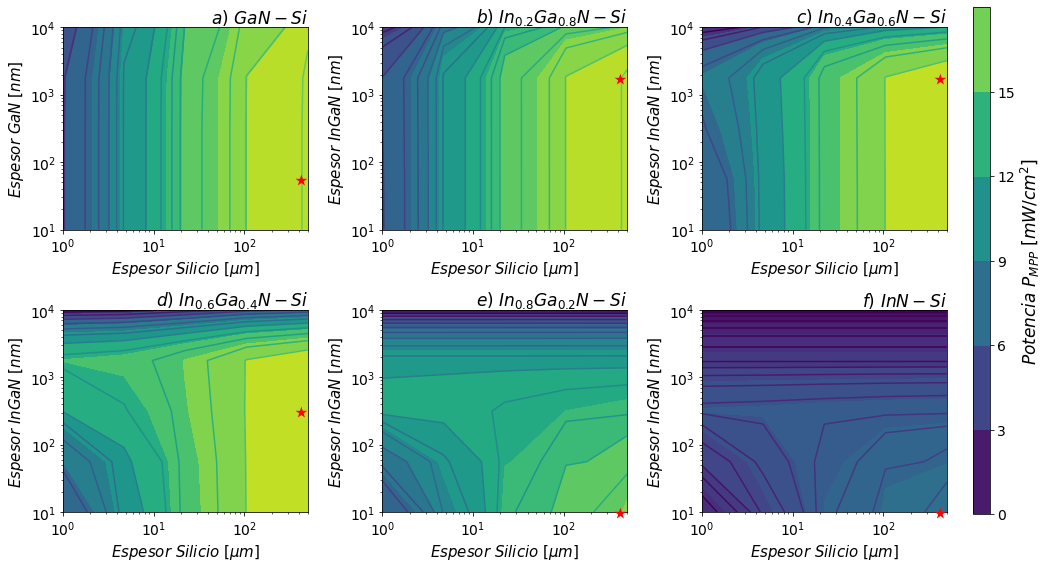

In [17]:
import numpy as np
import matplotlib.pyplot as plt

labelsize = 15
conc_n_list = np.linspace(0,1, 6)
min = 0
max= 21
levels = np.linspace(min, 18, 7)
set_color = 'hot'
lines = 15
i = 0
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches((12, 8))
dictionario = {}
lim = 16
lim2 = 19

for ax in axes.flat:
    if i == 0:
          imag = ax.contour(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 7, data[i], lines,levels = levels, vmin = min + 3, vmax = max + 3)#, cmap = set_color)
          imag = ax.contourf(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 7, data[i],10,levels = levels, vmin = min, vmax = max)#, cmap = set_color)
          plt.tight_layout()
    im = ax.contour(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 7, data[i], lines, vmin = min + 3, vmax = max + 3)#, cmap = set_color)
    im = ax.contourf(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 7, data[i],10,  vmin = min, vmax = max)#, cmap = set_color)
    ax.set_xscale('log')
    ax.set_yscale('log')    
    ax.text(w_Si_p_list[-1] * 10 ** 4, w_IGN_n_list[-1] * 10 ** 7, s = r'${}$'.format(Names[i]), fontsize = 17, ha = 'right', va = 'bottom')
    plt.tight_layout()

    pos = np.where(data[i] == np.amax(data[i]))
    a = pos[0][0]
    b = pos[1][0]
    c = '{:.2f}'.format(data[i][a][b])
    print(w_IGN_n_list[a] * 10 ** 4, w_Si_p_list[b] * 10 ** 4, c)
    ax.text(x = w_Si_p_list[b] * 10**4 , y = w_IGN_n_list[a] * 10 ** 7, s = r'$\star $', fontsize = 30, ha = 'right', va = 'center', color = 'r')
    

    mask = (data[i] > lim) & (data[i] < lim2)
    listado = np.where(mask)
    y = listado[0]
    x = listado[1]
    print('#############')
    #for a,b in zip(y,x):
    #  ax.text(x = w_Si_p_list[b] * 10**4 , y = w_IGN_n_list[a] * 10 ** 7, s = r'$.$', fontsize = 15, ha = 'center', va = 'bottom', color = 'k')

    ax.set_xlabel(r'$Espesor\ Silicio\ [\mu m]$', fontsize = labelsize)
    ax.set_ylabel(r'$Espesor\ InGaN\ [nm]$',   fontsize = labelsize)   
    if i == 0:
      ax.set_ylabel(r'$Espesor\ GaN\ [nm]$',   fontsize = labelsize)
    elif i == 5:
      ax.set_ylabel(r'$Espesor\ InN\ [nm]$',   fontsize = labelsize)
    i += 2

fig.tight_layout()
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([1.13, 0.1, 0.02, 0.88])
cbar = fig.colorbar(imag,extend = 'max', cax=cbar_ax, label='digit value', ticks = [0,3,6,9,12, 15])
cbar.set_label(r"$Potencia\ P_{MPP}\ [mW/cm^{2}]$", size = 17)
np.amax(np.array(Eff_list))

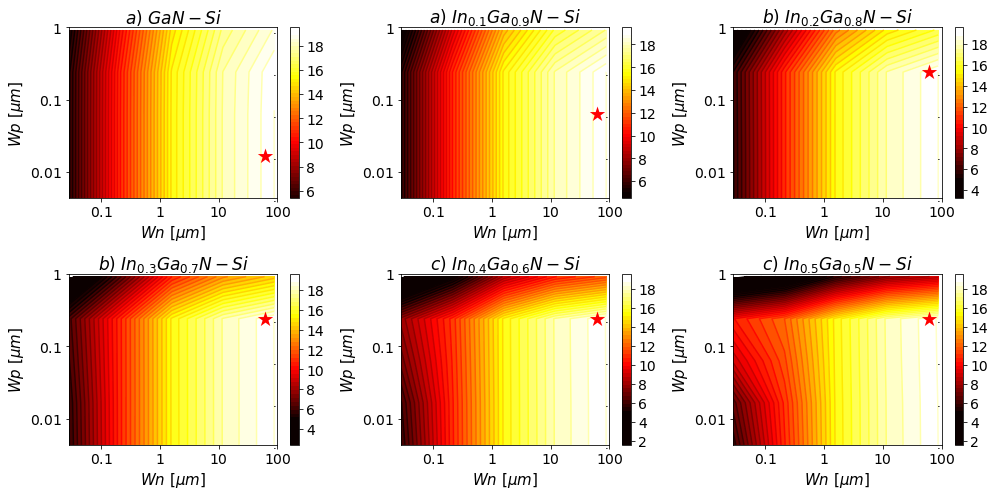

In [18]:
import numpy as np
import matplotlib.pyplot as plt

anchor= pixels / 8
initial_y = anchor
final_y = pixels - 1.5 * anchor
medium_y = initial_y + (final_y - initial_y) / 2
initial_x = anchor
final_x = pixels - 1.5 * anchor
second_x = initial_y + (final_x - initial_x) / 3
third_x = initial_y + 2 * (final_x - initial_x) / 3
labelsize = 15
conc_n_list = np.linspace(0,1, 6)

min = 5
max= 19
i = 0
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches((14, 7))
for cont in range(1,7):
    plt.subplot(2,3,cont)
    plt.contour(data[i], 50, cmap=colors[-3], vmin = min+1, vmax = max+1)
    plt.contourf(data[i], 50, cmap=colors[-3], vmin = min, vmax = max)
    plt.colorbar(ticks = np.arange(0, 20, 2))
    
    plt.xticks([initial_x, second_x, third_x, final_x], [r'$0.1$', r'$1$', r'$10$', r'$100$'])
    plt.yticks([initial_y, medium_y, final_y], [r'$0.01$', r'$0.1$', r'$1$'])
    plt.title(r'${}$'.format(Names[i]), fontsize = 17, va = 'center')

    pos = np.where(data[i] == np.amax(data[i]))
    a = pos[0][0]
    b = pos[1][0]
    c = '{:.2f}'.format(data[i][a][b])
    plt.text(b, a, s = r'$\star $', fontsize = 40, ha = 'right', va = 'center', color = 'r')
    listado = np.where(np.round(data[i], 0) == np.max(np.round(data[0], 0)))
    x = listado[0]
    y = listado[1]
    for a,b in zip(x,y):
      plt.text(b, a, s = r'$.$', fontsize = 12, ha = 'center', va = 'center', color = 'k')

  
    #plt.xticklabels()
    #plt.yticklabels()
    plt.xlabel(r'$Wn\ [\mu m]$', fontsize = labelsize)
    plt.ylabel(r'$Wp\ [\mu m]$',   fontsize = labelsize)
    
    #if i == 0:
    #  ax.set_ylabel(r'$Espesor\ GaN\ [\mu m]$',   fontsize = labelsize)
    #elif i == 5:
    #  ax.set_ylabel(r'$Espesor\ InN\ [\mu m]$',   fontsize = labelsize)
    i += 1

plt.tight_layout()
#fig.subplots_adjust(right=1.1)
#cbar_ax = fig.add_axes([1.13, 0.1, 0.02, 0.88])
#cbar = fig.colorbar(imag, cax=cbar_ax, label='digit value', ticks = [0,3,6,9,12, 15, 18])
#cbar.set_label(r"$Potencia\ P_{MPP}\ [mW/cm^{2}]$", size = 17)

# Important results

In [19]:
def J_V_GRAPH(V_list, J_lists, xlim = 0.7, ylim = 40, label_size = 15, legend_size = 15, title_size = 18, title_legend = r'$In_{X}Ga_{1-x}N$'):
    for i, j in enumerate(conc_n_list):
        if conc_n_list[i] > 0.75:
          plt.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2, ls = '--')
        else:
          plt.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
    plt.title(r'$a)\ Densidad\ de\ corriente$', fontsize = title_size)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xlabel(r'$Voltaje\ [V]$', fontsize = label_size)
    plt.ylabel(r'$J\ [mA/cm^{2}]$', fontsize = label_size)
    plt.legend(fontsize = legend_size, loc = 'best', title = title_legend)
    plt.grid('on')
    plt.tight_layout()

def P_V_GRAPH(V_list, Pot_lists, xlim = 0.7, ylim = 20, label_size = 15, legend_size = 15, title_size = 18, title_legend = r'$In_{X}Ga_{1-x}N$'):
    for i, j in enumerate(conc_n_list):
        if conc_n_list[i] > 0.75:
          plt.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2, ls = '--')
        else:
          plt.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
    plt.title(r'$b)\ Densidad\ de\ potencia$', fontsize = title_size)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xlabel(r'$Voltaje\ [V]$', fontsize = label_size)
    plt.ylabel(r'$P\ [mW/cm^{2}]$', fontsize = label_size)
    plt.legend(fontsize = legend_size, loc = 'best', title = title_legend)
    plt.grid('on')
    plt.tight_layout()

def characteristic_graph(conc_n_list, data, title, ylabel, limits, axes_size = 15, title_size = 18):
      plt.plot(conc_n_list, data, lw = 2.5)
      plt.ylim(0)
      plt.ylim(limits[0], limits[1])
      plt.xlim(0.1,0.8)
      plt.ylabel(ylabel = ylabel, fontsize = axes_size)
      plt.title(label = title, fontsize = title_size)
      plt.xlabel(r'$x $', fontsize = axes_size)
      plt.grid()
      plt.axvline(0.7, ls = '--', color = 'r')
      plt.xticks([0, 0.2, 0.4, 0.6, 0.8])

In [20]:
V_list = np.linspace(0, 1, 101)
J_lists, Pot_lists = [], []
Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []

N_IGN_n     = 10 ** 14
N_Si_p      = 1 * 10 ** 16
w_IGN_n     = 0.1 * 10 ** - 4
w_Si_p      = 150 * 10 ** - 4
conc_n_list = list(np.linspace(0, 0.6, 5)) #+ [0.9, 1]#[0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1]#np.linspace(0.15, 0.9, 6)
for conc_n in conc_n_list:
    J_list, Pot_list,x_n_list, x_p_list = basic_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
    J_lists.append(J_list)
    Pot_lists.append(Pot_list)

    Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
    Jsc_list.append(Jsc)
    Voc_list.append(Voc)
    FF_list.append(FF)
    Eff_list.append(Eff)


J_lists_, Pot_lists_ = [], []
Jsc_list_, Voc_list_, FF_list_, Eff_list_ = [], [], [], []

conc_n_list_ = np.linspace(0, 0.8, 100)
for conc_n in conc_n_list_:
    J_list_, Pot_list_, x_n_list_, x_p_list_ = basic_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
    J_lists_.append(J_list_)
    Pot_lists_.append(Pot_list_)

    Voc_, Jsc_, FF_, Eff_, xn_opt_, xp_opt_ = CHARACTERISTICS_VALUES(J_list_, Pot_list_, V_list)
    Jsc_list_.append(Jsc_)
    Voc_list_.append(Voc_)
    FF_list_.append(FF_)
    Eff_list_.append(Eff_)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


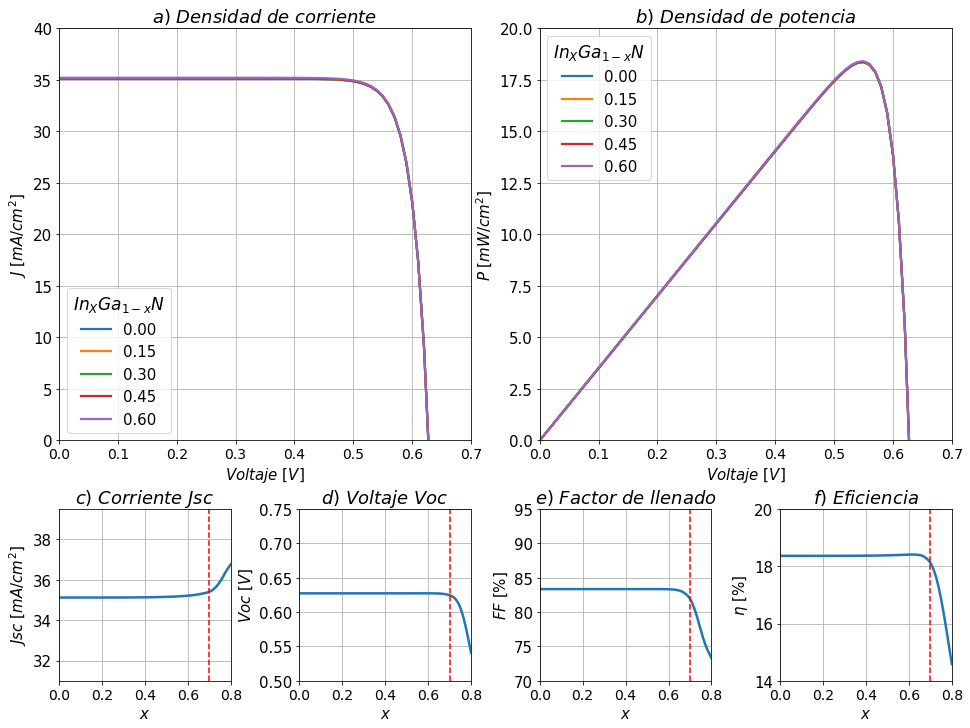

In [21]:
fig = plt.figure(figsize=(16, 12))
title_size = 18
axes_size = 15
params = {'xtick.labelsize': 14, 'ytick.labelsize': 15, 'legend.title_fontsize' : 17}
mpl.rcParams.update(params)

map_label = {(0, 0) : r'$Jsc\ [mA/cm^{2}]$', 
             (0, 1) : r'$Voc\ [V]$',
             (1, 0) : r'$FF\ [\%]$',
             (1, 1) : r'$\eta\ [\%]$'}
map_title = {(0, 0) : r'$c)\ Corriente\ Jsc$', 
             (0, 1) : r'$d)\ Voltaje\ Voc$',
             (1, 0) : r'$e)\ Factor\ de\ llenado$',
             (1, 1) : r'$f)\ Eficiencia$'}
rows = 3
columns = 4
grid = plt.GridSpec(rows, columns, wspace = .4, hspace = .4)

plt.subplot(grid[:2, :2])
J_V_GRAPH(V_list, J_lists)

plt.subplot(grid[:2, 2:])
P_V_GRAPH(V_list, Pot_lists)

plt.subplot(grid[2, 0])
characteristic_graph(conc_n_list_,  Jsc_list_, map_title[(0, 0)], map_label[(0, 0)], (31, 39.5))

plt.subplot(grid[2, 1])
characteristic_graph(conc_n_list_,  Voc_list_, map_title[(0, 1)], map_label[(0, 1)], (0.5, 0.75))
plt.tight_layout()

plt.subplot(grid[2, 2])
characteristic_graph(conc_n_list_,  FF_list_, map_title[(1, 0)], map_label[(1, 0)], (70, 95))
plt.tight_layout()

plt.subplot(grid[2, 3])
characteristic_graph(conc_n_list_,  np.array(Eff_list_) * 100, map_title[(1, 1)], map_label[(1, 1)], (14, 20))
plt.tight_layout()

#tables

In [22]:
dictio = {'Espesor Ventana [µm]' : [], 'Espesor Absorbente [µm]' : [],  'Potencia MPP [mW/cm²]' : []}
times = 8
ind = [i/10 for i in range(0, times)]
lim = 15
lim2 = 100

for cont in range(times):
  mask = (data[cont] > lim) & (data[cont] < lim2)
  listado = np.where(mask)
  x = listado[1]
  y = listado[0]
  min = 10 ** 10
  max = 0
  for i, j in zip(x, y):
    cant = w_IGN_n_list[j] * 10 ** 4
    if cant > max: max = cant
    if cant < min: min = cant
  pos = np.where(data[cont] == np.amax(data[cont]))
  a = pos[0][0]
  b = pos[1][0]
  c = data[0][a][b]
  dictio['Espesor Ventana [µm]'].append('(' + str(np.round(min,2)) + ' - ' + str(round(max, 2)) + ')  Óptimo: {:.2f}*'.format(w_IGN_n_list[a] * 10 ** 4))

for cont in range(times):
  mask = (data[cont] > lim) & (data[cont] < lim2)
  listado = np.where(mask)
  x = listado[1]
  y = listado[0]
  min = 10 ** 10
  max = 0
  for i, j in zip(x, y):
    cant = w_Si_p_list[i] * 10 ** 4
    if cant > max: max = cant
    if cant < min: min = cant
    if max > 600: max = 500
  pos = np.where(data[cont] == np.amax(data[cont]))
  a = pos[0][0]
  b = pos[1][0]
  c = data[0][a][b]
  dictio['Espesor Absorbente [µm]'].append('(' + str(np.round(min,2)) + ' - ' + str(round(max, 2)) + ') Óptimo: {:.0f}*'.format(w_Si_p_list[b] * 10 ** 4))


for cont in range(times):
  mask = (data[cont] > lim) & (data[cont] < lim2)
  listado = np.where(mask)
  x = listado[1]
  y = listado[0]
  min = 10 ** 10
  max = 0
  for i, j in zip(x, y):
    cant = data[cont][j][i]
    if cant > max: max = cant
    if cant < min: min = cant
    if max > 600: max = 500
  pos = np.where(data[cont] == np.amax(data[cont]))
  a = pos[0][0]
  b = pos[1][0]
  c = data[cont][a][b]
  dictio['Potencia MPP [mW/cm²]'].append('(' + str(np.round(min,2)) + ' - ' + str(round(max, 2)) + ') Óptimo: {:.2f}'.format(data[cont][a][b]))

for cont in range(times):
  mask = (data[cont] > lim) & (data[cont] < lim2)
  #dictio['Potencia MPP [mW/cm²]'].append(np.round(data[cont][mask].mean(), 2) )
  #dictio['η [%]'].append(np.round(data[cont][mask].mean()*100/P_inc, 2))
  #dictio['Jsc [mA/cm²]'].append(np.round(datajsc[cont][mask].mean(), 2))
  #dictio['Voc [V]'].append(np.round(datavoc[cont][mask].mean(), 5))
DF = pd.DataFrame(data = dictio, index = ind)
DF.columns.name = 'Estequiometría'
#DF['Jsc [mA/cm²]'] = np.round(DF['Pmpp [mW/cm²]'] / DF['Voc [V]'], 2)
#DF.style.set_properties(**{'text-align': 'Ccenter'})
DF

Estequiometría,Espesor Ventana [µm],Espesor Absorbente [µm],Potencia MPP [mW/cm²]
0.0,(0.01 - 10.0) Óptimo: 0.06*,(22.36 - 500.0) Óptimo: 500*,(15.12 - 19.2) Óptimo: 19.20
0.1,(0.01 - 10.0) Óptimo: 0.32*,(22.36 - 500.0) Óptimo: 500*,(15.67 - 19.2) Óptimo: 19.20
0.2,(0.01 - 10.0) Óptimo: 1.78*,(22.36 - 500.0) Óptimo: 500*,(15.35 - 19.2) Óptimo: 19.20
0.3,(0.01 - 1.78) Óptimo: 1.78*,(22.36 - 500.0) Óptimo: 500*,(15.67 - 19.21) Óptimo: 19.21
0.4,(0.01 - 1.78) Óptimo: 1.78*,(22.36 - 500.0) Óptimo: 500*,(15.67 - 19.22) Óptimo: 19.22
0.5,(0.01 - 1.78) Óptimo: 1.78*,(22.36 - 500.0) Óptimo: 500*,(15.67 - 19.25) Óptimo: 19.25
0.6,(0.01 - 1.78) Óptimo: 0.32*,(22.36 - 500.0) Óptimo: 500*,(15.68 - 19.27) Óptimo: 19.27
0.7,(0.01 - 1.78) Óptimo: 0.01*,(4.73 - 500.0) Óptimo: 500*,(15.02 - 19.17) Óptimo: 19.17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Eff: 19.20253852445501 Pot: 19.20253852445501


<Figure size 432x288 with 0 Axes>

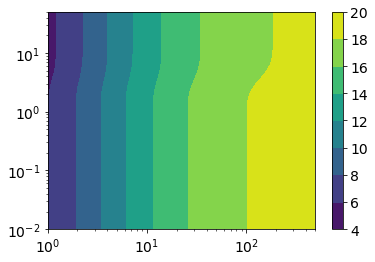

Eff: 19.207688259543147 Pot: 19.207688259543147


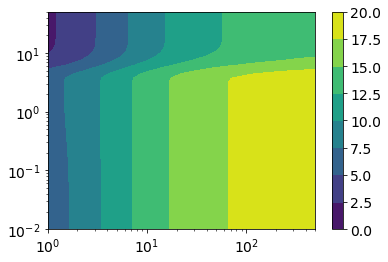

In [ ]:
%%time
from itertools import product
import matplotlib as mpl
colors = ['CMRmap', 'GnBu', 'Greys' 'OrRd', 'Oranges', 'Pubu' 'Reds', 'YlOrBr', 'YlOrRd', 'afmhot', 'copper', 'gist_heat', 'hot', 'inferno', 'jet']
params = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.title_fontsize' : 12}
mpl.rcParams.update(params)
plt.figure()
pixels = 50
data = []
datavoc = []
datajsc = []

N_IGN_n      =  10 ** 14
N_Si_p       =  10 ** 16
w_IGN_n_list =  np.logspace(-6, -2.3, pixels)
w_Si_p_list  =  np.logspace(-4, np.log10(0.05), pixels) 
cross_product = list(product(w_IGN_n_list, w_Si_p_list))
cont = 1
conc_n_list = [0, 0.2, 0.4, 0.6, 0.8, 1] #np.linspace(0,1, 6)


for conc_n in [0, 0.3,0.6]:#conc_n_list:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
    Pmpp_list = []
    eureca = 0
    eureca2 = 0
    for w_IGN_n, w_Si_p in cross_product:
        J_list, Pot_list, x_n_list, x_p_list = basic_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
        Pot_list = np.array(Pot_list)
        Pmpp_list.append(np.amax(Pot_list[Pot_list >= 0]))
        J_lists.append(J_list)
        Pot_lists.append(Pot_list)
        Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
        if Eff > eureca and Eff < 100:
          eureca = Eff
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)
    values1 = (np.array(Pmpp_list) * 1000).reshape(pixels, -1)
    data.append(values1)
    values = (np.array(Voc_list)).reshape(pixels, -1)
    datavoc.append(values)
    values = (np.array(Jsc_list)).reshape(pixels, -1)
    datajsc.append(values)
    print('Eff:', np.amax(np.array(Eff_list)) * 100, 'Pot:', np.amax(values1))
    plt.figure()
    plt.contourf(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 4, values1)
    plt.colorbar()
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [ ]:
#auxiliar lists, for label the graphs
lista_1 = [0.3, 0.6]
lista_2 =  [0.7, 0.4]
lista_3 = ['b)\ ', 'c)\ ']
Names = ['a)\ GaN-Si']
cont = 0
for i,j in zip(lista_1, lista_2):
  Names.append(lista_3[cont] + 'In_{' + str(i) + '}Ga_{' + str(j) + '}N-Si')
  cont += 1
Names

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
labelsize = 15
conc_n_list = np.linspace(0,1, 6)
min = 0
max= 19
levels = [0, 3, 6, 9, 12, 15, 18, 21]
levels2 = [0, 3, 6, 9, 12, 15, 18, 18.5, 19]

lines = 50
lineslines = 20

i = 0
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches((12, 4.5))
dictionario = {}


lim = 1699
lim2 = 1900000

for ax in axes.flat:
    if i == 0:
          imag = ax.contour(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 4, data[i], lineslines, vmin = min + 3, vmax = max + 3)#, cmap = set_color)
          imag = ax.contourf(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 4, data[i],lines, vmin = min, vmax = max, levels = levels)#, cmap = set_color)
          plt.tight_layout()
    im = ax.contour(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 4, data[i], lineslines, vmin = min + 3, vmax = max + 3)#, cmap = set_color)
    im = ax.contourf(w_Si_p_list *10 ** 4, w_IGN_n_list * 10 ** 4, data[i],  vmin = min, vmax = max, levels = levels)#, cmap = set_color)
    ax.set_xscale('log')
    ax.set_yscale('log')    
    ax.text(w_Si_p_list[-1] * 10 ** 4, w_IGN_n_list[-1] * 10 ** 4, s = r'${}$'.format(Names[i]), fontsize = 17, ha = 'right', va = 'bottom')
    plt.tight_layout()

    pos = np.where(data[i] == np.amax(data[i]))
    a = pos[0][0]
    b = pos[1][0]
    c = '{:.2f}'.format(data[i][a][b])
    print(w_IGN_n_list[a] * 10 ** 4, w_Si_p_list[b] * 10 ** 4, c)
    ax.text(x = w_Si_p_list[b] * 10**4 , y = w_IGN_n_list[a] * 10 ** 4, s = r'$\star $', fontsize = 40, ha = 'right', va = 'center', color = 'r')
    #ax.text(x = w_IGN_n_list[b] * 10**4 , y = w_IGN_n_list[a] * 10 ** 4 , s = r'$\star $', fontsize = 40, ha = 'center', va = 'center', color = 'r')
    ax.text(x = w_Si_p_list[b] * 10**4 - 150, y = w_IGN_n_list[a] * 10 ** 4 + 0.1, s = r'$Óptimo $', fontsize = 14, ha = 'right', va = 'center', color = 'k')
    

    mask = (data[i] > lim) & (data[i] < lim2)
    listado = np.where(mask)
    y = listado[0]
    x = listado[1]
    print('#############')
    #for a,b in zip(y,x):
    #  ax.text(x = w_Si_p_list[b] * 10**4 , y = w_IGN_n_list[a] * 10 ** 7, s = r'$.$', fontsize = 15, ha = 'center', va = 'bottom', color = 'k')

    ax.set_xlabel(r'$Espesor\ Silicio\ [\mu m]$', fontsize = labelsize)
    ax.set_ylabel(r'$Espesor\ InGaN\ [\mu m]$',   fontsize = labelsize)   
    if i == 0:
      ax.set_ylabel(r'$Espesor\ GaN\ [\mu m]$',   fontsize = labelsize)
    elif i == 5:
      ax.set_ylabel(r'$Espesor\ InN\ [nm]$',   fontsize = labelsize)
    i += 1

fig.tight_layout()
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([1.13, 0.1, 0.015, 0.88])
cbar = fig.colorbar(imag, extend = 'max', cax=cbar_ax, ticks = [0,3,6,9,12, 15,18]) #,extend = 'max'
cbar.set_label(r"$Potencia\ P_{MPP}\ [mW/cm^{2}]$", size = 17)
np.amax(np.array(Eff_list))

# Doping simulation 

In [ ]:
fig = plt.figure(figsize=(19, 8))
title_size = 18
axes_size = 15
params = {'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.title_fontsize' : 17}
mpl.rcParams.update(params)

map_label = {(0, 0) : r'$Jsc\ [mA/cm^{2}]$', 
             (0, 1) : r'$Voc\ [V]$',
             (1, 0) : r'$FF\ [\%]$',
             (1, 1) : r'$\eta\ [\%]$'}
map_title = {(0, 0) : r'$a.\ Corriente\ Jsc$', 
             (0, 1) : r'$b.\ Voltaje\ Voc$',
             (1, 0) : r'$c.\ Factor\ de\ llenado$',
             (1, 1) : r'$d.\ Eficiencia$'}
rows = 2
columns = 4
grid = plt.GridSpec(rows, columns, wspace = .4, hspace = .4)


plt.subplot(grid[:, :2])
Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
N_LIST = np.logspace(14, 19, 6)
for N_Si_p in N_LIST:
  w_IGN_n_list    =  np.array([0.1, 1, 10]) * 10 ** -5
  w_Si_p_list    =  np.array([1, 10, 100]) * 10 ** -5
  N_IGN_n = 10 ** 16
  N_Si_p = N_Si_p
  w_IGN_n     =  0.1 * 10 ** - 4
  w_Si_p      =  100 * 10 ** - 4
  conc_n = 0 
  J_list, Pot_list, x_n_list, x_p_list = basic_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
  Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
  Jsc_list.append(Jsc)
  Voc_list.append(Voc)
  FF_list.append(FF)
  Eff_list.append(Eff)
  plt.plot(V_list, np.array(J_list) * 10 ** 3, label = '{:.0e}'.format(N_Si_p), lw = 2.5)
  plt.xlim(0, 0.8)
  plt.ylim(0, 40)
plt.grid()
plt.legend(title = r'$Dopaje\ [cm^{-3}]$', fontsize = 17)
plt.xlabel(r'$Voltaje\ [V]$', fontsize = 17)
plt.ylabel(r'$J\ [mA/cm^{2}]$', fontsize = 17)
plt.title(r'$Densidad\ de\ corriente$', fontsize = 20)


V_list = np.linspace(0, 1, 101)
Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
N_LIST = [1 * 10 ** 14, 1 * 10 ** 15, 1 * 10 ** 16, 1 * 10 ** 17, 1 * 10 ** 18, 1 * 10 ** 19]
N_LIST = np.logspace(13, 19, 20)
for N_Si_p in N_LIST:

  w_IGN_n_list    =  np.array([0.1, 1, 10]) * 10 ** -5
  w_Si_p_list    =  np.array([1, 10, 100]) * 10 ** -5
  N_IGN_n = 10 ** 16
  N_Si_p = N_Si_p
  w_IGN_n     =  0.1 * 10 ** - 4
  w_Si_p      =  100 * 10 ** - 4

#N_IGN_n     = 10 ** 16
#N_Si_p      = 10 ** 14
#w_IGN_n     = 0.9 * 10 ** - 4
#w_Si_p      = 100 * 10 ** - 4

  conc_n = 0 #np.linspace(0.15 ,0.75, 5)
  J_list, Pot_list, x_n_list, x_p_list = basic_simulation_V(N_IGN_n, N_Si_p, w_IGN_n, w_Si_p)
  Voc, Jsc, FF, Eff, xn_opt, xp_opt = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
  Jsc_list.append(Jsc)
  Voc_list.append(Voc)
  FF_list.append(FF)
  Eff_list.append(Eff)
plt.subplot(grid[0, 2])
plt.plot(N_LIST, Jsc_list,'o')
plt.ylabel(map_label[(0, 0)], fontsize = axes_size)
plt.title(map_title[(0, 0)], fontsize = title_size)
plt.xlabel(r'$Dopaje\ [cm^{-3}]$', fontsize = axes_size)
plt.xscale('log')
plt.grid()

plt.subplot(grid[0, 3])
plt.tight_layout()
plt.plot(N_LIST, Voc_list,'o')
plt.ylabel(map_label[(0, 1)], fontsize = axes_size)
plt.title(map_title[(0, 1)], fontsize = title_size)
plt.xlabel(r'$Dopaje\ [cm^{-3}]$', fontsize = axes_size)
plt.xscale('log')
plt.grid()

plt.subplot(grid[1, 2])
plt.plot(N_LIST, FF_list,'o')
plt.ylabel(map_label[(1, 0)], fontsize = axes_size)
plt.title(map_title[(1, 0)], fontsize = title_size)
plt.xlabel(r'$Dopaje\ [cm^{-3}]$', fontsize = axes_size)
plt.xscale('log')
plt.grid()

ball_size =20
plt.subplot(grid[1, 3])
plt.plot(N_LIST, np.array(Eff_list) * 100, 'o', lw = ball_size)
plt.ylabel(map_label[(1, 1)], fontsize = axes_size)
plt.title(map_title[(1, 1)], fontsize = title_size)
plt.xlabel(r'$Dopaje\ [cm^{-3}]$', fontsize = axes_size)
plt.xscale('log')
pos = np.where(np.array(Eff_list) == np.amax(np.array(Eff_list)))[0][0]
N_opt = N_LIST[pos]
ef_opt = Eff_list[pos]
plt.axvline(x = N_opt, ls = '--', color = 'r')
plt.axhline(y = ef_opt * 100, ls = '--', color = 'r')
plt.grid()